In [ ]:
!pip install grad_cam
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s 

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.6 MB/s eta 0:00:00


### Import all the libraries

In [ ]:
# Land cover classifier with Resnet + GPT-AV integration(streamlit UI)
import streamlit as st
import torch
import torchvision.transforms as transforms
from torchvision import models,datasets
from torch.utils.data import dataloader,random_split
import torch.nn as nn
import torch.optim as optim
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io
import openai
import base64
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import os

## Load the dataset

In [ ]:
from torchvision import transforms
#Load Eurosat RGB dataset
#Transformation for preprocessing and argumentation
transform_pipeline=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #standard imagenet normalization
])
#download Eurosat RGB dataset
dataset=datasets.EuroSAT(root='./data',download=True,transform=transform_pipeline)

CLASS_NAMES=['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

print(f"Classes: {CLASS_NAMES}")

100%|██████████| 94.3M/94.3M [00:00<00:00, 258MB/s]


Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Train-validation split

In [ ]:
#Train-validation split
train_size=int(0.8*len(dataset))
val_size=len(dataset)-train_size
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

train_loader=dataloader.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2)
val_loader=dataloader.DataLoader(val_dataset,batch_size=32,shuffle=False,num_workers=2)


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Load pretrained Resnet-50
resnet_model=models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

resnet_model.fc=nn.Linear(resnet_model.fc.in_features,10)
torch.save(resnet_model.state_dict(), '/content/drive/MyDrive/Pytorch/resnet50_eurosat.pth') #Save the model into the specified path
resnet_model.eval()
resnet_model.to(device)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Loss & optimizer
learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate)

In [ ]:
from tqdm import tqdm
#Training Loop
def train_model(resnet_model, train_loader, val_loader, criterion, optimizer, epochs=5):
    best_acc = 0.0
    for epoch in range(epochs):
        resnet_model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

        # Validate
        val_acc = evaluate_model(resnet_model, val_loader)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(resnet_model.state_dict(), '/content/drive/MyDrive/Pytorch/best_model.pth')


            print("Saved the best model")

def evaluate_model(resnet_model, loader):
    resnet_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")
    return acc

train_model(resnet_model, train_loader, val_loader, criterion, optimizer, epochs=5)



def predict_resnet(image, resnet_model):
    input_tensor = transform_pipeline(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = resnet_model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0][predicted].item()
    return CLASS_NAMES[predicted.item()], confidence

Epoch 1/5: 100%|██████████| 675/675 [03:29<00:00,  3.23it/s]

Epoch [1/5] - Loss: 1.7962, Train Acc: 0.5349


Validation Accuracy: 0.7202
Saved the best model


Epoch 2/5: 100%|██████████| 675/675 [03:32<00:00,  3.18it/s]

Epoch [2/5] - Loss: 0.9500, Train Acc: 0.7761


Validation Accuracy: 0.8537
Saved the best model


Epoch 3/5: 100%|██████████| 675/675 [03:31<00:00,  3.20it/s]

Epoch [3/5] - Loss: 0.5805, Train Acc: 0.8490


Validation Accuracy: 0.8894
Saved the best model


Epoch 4/5: 100%|██████████| 675/675 [03:31<00:00,  3.20it/s]

Epoch [4/5] - Loss: 0.4106, Train Acc: 0.8869


Validation Accuracy: 0.9243
Saved the best model


Epoch 5/5: 100%|██████████| 675/675 [03:31<00:00,  3.19it/s]

Epoch [5/5] - Loss: 0.3115, Train Acc: 0.9108


Validation Accuracy: 0.9398
Saved the best model


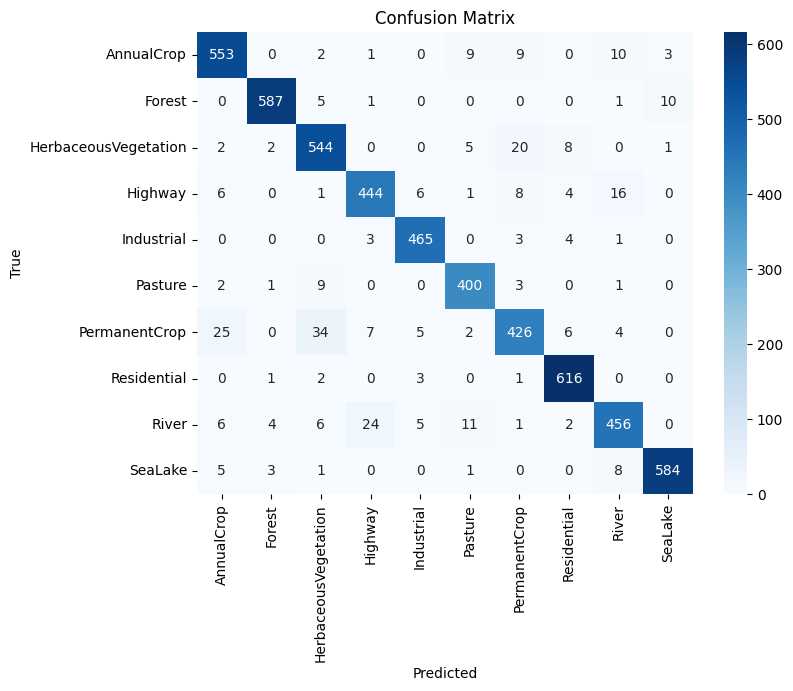

In [ ]:

all_preds,all_labels=[],[]
with torch.no_grad():
    resnet_model.eval()
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Confusion matrix
conf_matrix=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=CLASS_NAMES,yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install Grad-CAM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 839.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.7 MB/s

GRAD-CAM Feature map

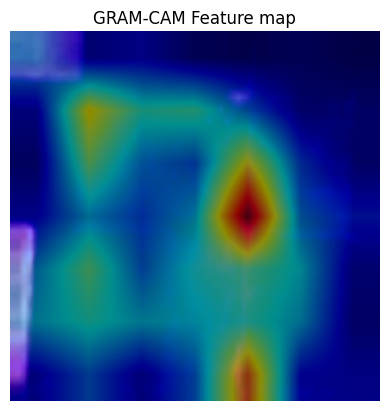

In [ ]:
#Feature map visualization
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

#Pick an image
samples, _= dataset[0]
input_tensor=samples.unsqueeze(0).to(device)

#GRAM-CAM on last convolutional layer
target_layers=[resnet_model.layer4[-1]]
cam=GradCAM(model=resnet_model,target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor)[0, :]


#Convert numpy for overlay
rgb_image=samples.permute(1,2,0).cpu().numpy()
rgb_image=np.clip(rgb_image,0,1)
visualization=show_cam_on_image(rgb_image,grayscale_cam,use_rgb=True)


plt.imshow(visualization)
plt.title('GRAM-CAM Feature map')
plt.axis('off')
plt.show()




In [ ]:
#Import the files
from google.colab import files

Saving Industrial_6.jpg to Industrial_6.jpg


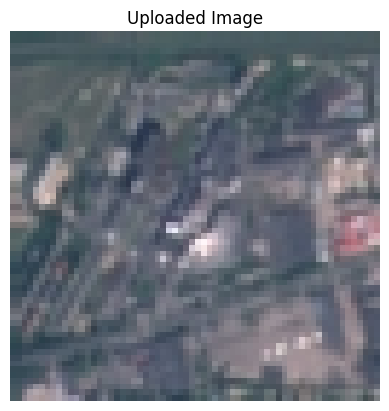

In [ ]:
uploaded = files.upload()
image_path = next(iter(uploaded))
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title("Uploaded Image")
plt.axis('off')
plt.show()

In [ ]:
#PREDICT THE TYPE
label, conf = predict_resnet(image, resnet_model)
print(f" ResNet Prediction: {label} ({conf:.2%} confidence)")

🔍 ResNet Prediction: Industrial (56.55% confidence)


### GPT-4o Integration

In [ ]:
import openai

client = openai(api_key="YOUR_API_KEY")
def query_gpt4o_with_image(image,resnet_model):
    img_bytes = io.BytesIO()
    image.save(img_bytes, format='PNG')
    base64_image = base64.b64encode(img_bytes.getvalue()).decode()

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "This is a satellite image. What land cover type is this? Choose from: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake."
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        max_tokens=300
    )

    return response.choices[0].message.content


In [ ]:
import openai

try:
    gpt_response = query_gpt4o_with_image(image, resnet_model)
    print(gpt_response)
except openai.RateLimitError:
    print("GPT-4 Vision quota exceeded. Please check your billing or try again later.")
except Exception as e:
    print("Unexpected error:", e)


The image appears to show a mix of large buildings, roads, and paved surfaces, which is characteristic of an **Industrial** land cover. This type of area often includes factories, warehouses, and other facilities related to manufacturing and processing. The structures and layout differ significantly from residential areas or natural landscapes such as forests or rivers. The presence of organized infrastructure suggests industrial activities.


## Wrapp these into streamlit

In [ ]:
!pip install streamlit pyngrok -q


In [ ]:
# Start Streamlit in background
!streamlit run app.py &>/dev/null &


In [ ]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
from PIL import Image
import torch
from torchvision import models, transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Model and class setup
CLASS_NAMES = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial',
               'Pasture','PermanentCrop','Residential','River','SeaLake']

@st.cache_resource
def load_model():
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.load_state_dict(torch.load('/content/drive/MyDrive/Pytorch/best_model.pth'))
    model.eval()
    return model

model = load_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Upload and predict
st.title("✅ EuroSAT Land Cover Classifier")
st.write("Upload a satellite image to classify land cover using ResNet-50 + GradCAM.")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_container_width=True)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        confidence = torch.nn.functional.softmax(output, dim=1)[0][predicted.item()].item()
        predicted_label = CLASS_NAMES[predicted.item()]

    st.success(f"✅ Predicted: **{predicted_label}** ({confidence:.2%} confidence)")

    # Grad-CAM visualization
    st.subheader(" Grad-CAM Heatmap")
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]

    # Convert to numpy for overlay
    img_np = np.array(image.resize((224, 224))).astype(np.float32) / 255
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    st.image(visualization, caption="Grad-CAM Heatmap", use_container_width=True)
""")


In [ ]:
#ngrok authentication
!ngrok config add-authtoken YOUR_NROK_AUTHTOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
#Kill existing tunnels to prevent 3-session limit
from pyngrok import ngrok
ngrok.kill()

# Start ngrok fresh
public_url = ngrok.connect(addr="8501")
print("🌐 Open this public link:", public_url)

🌐 Open this public link: NgrokTunnel: "https://e14525948dd1.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!pkill -f streamlit
!pkill -f ngrok
